<a href="https://colab.research.google.com/github/creativechirag26/Machine_Learning_Projects/blob/main/Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Classification
**Author - Chirag Ingle**

It is an automatic Brain Tumor Classification that uses deep learning techniques.

NEED OF BRAIN TUMOR CLASSIFICATION:

Doctors and Medical Specialists diagnos a lot of Brain Tumor suffering patient. We all know that doctors have a tiresome schedule which might led to wrong treatment. So, this model is designed in such a way that it some tumor is detected, it can alert the professional to check this carefully.

###**RESOURCES**:
Google Colab Environment, Kaggle Dataset, T4 GPU

###**SUMMARY**:

1) Model is trained using BRAT dataset available on Kaggle.

2) This notebook uses VGG 16 Transfer learning model with last 3 layers trainable (excluding last layer).

3) Few sample images have been plotted using Matplotlib library.

4) MRI are classified into a) Pituitary Tumor b) No Tumor c)Meningioma Tumor d) Glioma Tumor.

5) Exports .h5 file whole model so as to deploy model whenever needed.

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip install kaggle

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!pip install opendatasets
import opendatasets as od
od.download(
    "https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri")

100%|██████████| 86.8M/86.8M [00:00<00:00, 91.0MB/s]


In [8]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random
import warnings

In [9]:
warnings.filterwarnings('ignore')

In [10]:
train_dir='/content/brain-tumor-classification-mri/Training'
test_dir='/content/brain-tumor-classification-mri/Testing'

train_labels=[]
train_paths=[]

#/content/brain-tumor-classification-mri/Training/pituitary_tumor

for label in tqdm(os.listdir(train_dir)):
  real_label=''
  if label in ['pituitary_tumor', 'pituitary']:
            real_label = 'pituitary'
  elif label in ['no_tumor', 'notumor']:
            real_label = 'notumor'
  elif label in ['meningioma', 'meningioma_tumor']:
            real_label = 'meningioma'
  elif label in ['glioma', 'glioma_tumor']:
            real_label = 'glioma'
  for image in os.listdir(train_dir+'/'+label):
            train_paths.append(train_dir+'/'+label+'/'+image)
            train_labels.append(real_label)

train_paths, train_labels = shuffle(train_paths, train_labels)

100%|██████████| 4/4 [00:00<00:00, 689.09it/s]


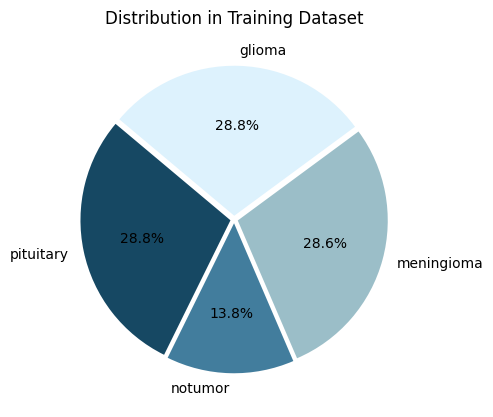

In [11]:
colors = ('#164863', '#427D9D', '#9BBEC8', '#DDF2FD')

label = ['pituitary', 'notumor', 'meningioma', 'glioma']

explode = (0.025, 0.025, 0.025, 0.025)

plt.figure(figsize=(5, 5))
plt.pie([len([x for x in train_labels if x == 'pituitary']),
         len([x for x in train_labels if x == 'notumor']),
         len([x for x in train_labels if x == 'meningioma']),
         len([x for x in train_labels if x == 'glioma'])],
        explode=explode,
        labels=['pituitary', 'notumor', 'meningioma', 'glioma'],
        colors=colors,
        autopct='%1.1f%%',
        startangle=140)

plt.title('Distribution in Training Dataset')
plt.tight_layout()
plt.show()

In [12]:
test_labels=[]
test_paths=[]

#/content/brain-tumor-classification-mri/Testing/pituitary_tumor

for label in tqdm(os.listdir(test_dir)):
  real_label=''
  if label in ['pituitary_tumor', 'pituitary']:
            real_label = 'pituitary'
  elif label in ['no_tumor', 'notumor']:
            real_label = 'notumor'
  elif label in ['meningioma', 'meningioma_tumor']:
            real_label = 'meningioma'
  elif label in ['glioma', 'glioma_tumor']:
            real_label = 'glioma'
  for image in os.listdir(test_dir+'/'+label):
            test_paths.append(test_dir+'/'+label+'/'+image)
            test_labels.append(real_label)

test_paths, test_labels = shuffle(test_paths, test_labels)

100%|██████████| 4/4 [00:00<00:00, 3057.63it/s]


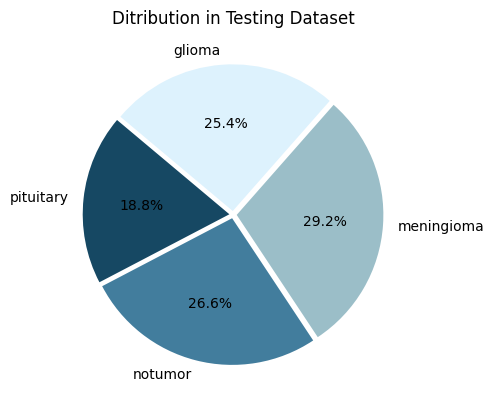

In [13]:
colors = ('#164863', '#427D9D', '#9BBEC8', '#DDF2FD')

label = ['pituitary', 'notumor', 'meningioma', 'glioma']

explode = (0.025, 0.025, 0.025, 0.025)

plt.figure(figsize=(5, 5))
plt.pie([len([x for x in test_labels if x == 'pituitary']),
         len([x for x in test_labels if x == 'notumor']),
         len([x for x in test_labels if x == 'meningioma']),
         len([x for x in test_labels if x == 'glioma'])],
        explode=explode,
        labels=['pituitary', 'notumor', 'meningioma', 'glioma'],
        colors=colors,
        autopct='%1.1f%%',
        startangle=140)

plt.title('Ditribution in Testing Dataset')
plt.tight_layout()
plt.show()

Dataset Distribution seems fine.

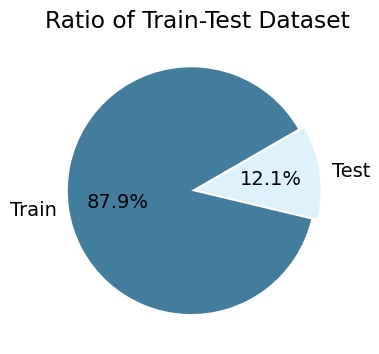

In [14]:
plt.figure(figsize=(4,4))
colors = ['#427D9D', '#DDF2FD']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);
plt.title('Ratio of Train-Test Dataset')
plt.tight_layout()
plt.show()

In [15]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

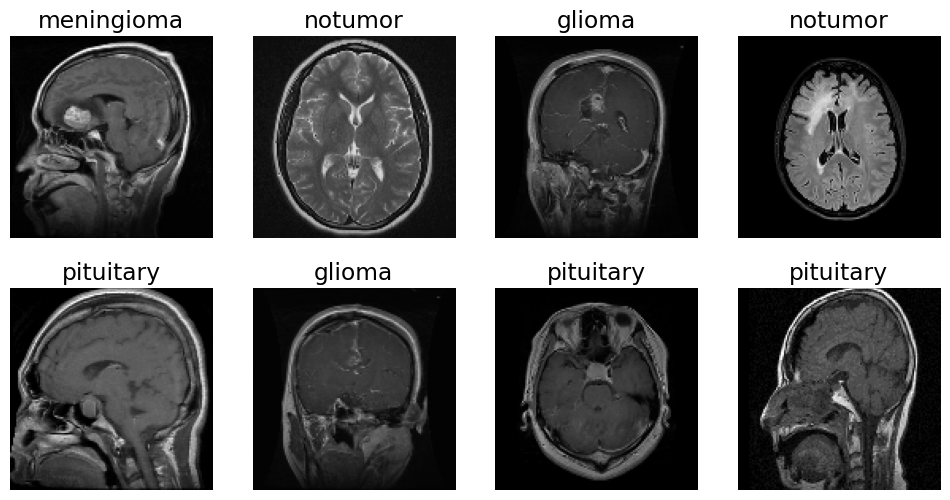

In [16]:
IMAGE_SIZE = 128

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

In [17]:
unique_labels = ['pituitary', 'meningioma', 'notumor', 'glioma']

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [18]:
strategy=tf.distribute.MirroredStrategy()

base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
          loss='sparse_categorical_crossentropy',
          metrics=['sparse_categorical_accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15763908 (60.13 MB)
Trainable params: 8128

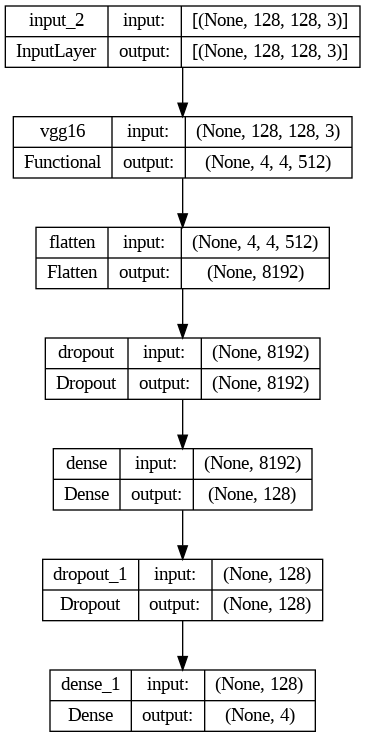

In [20]:
tf.keras.utils.plot_model(model,show_shapes=True,to_file='model.png')

In [21]:
batch_size = 25
steps = int(len(train_paths)/batch_size)
epochs = 10

history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
            epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
114/114 [==============================] - 36s 139ms/step - loss: 0.6575 - sparse_categorical_accuracy: 0.7295
Epoch 2/10
114/114 [==============================] - 14s 105ms/step - loss: 0.3691 - sparse_categorical_accuracy: 0.8633
Epoch 3/10
114/114 [==============================] - 13s 111ms/step - loss: 0.2516 - sparse_categorical_accuracy: 0.9062
Epoch 4/10
114/114 [==============================] - 12s 101ms/step - loss: 0.1889 - sparse_categorical_accuracy: 0.9262
Epoch 5/10
114/114 [==============================] - 11s 97ms/step - loss: 0.1856 - sparse_categorical_accuracy: 0.9276
Epoch 6/10
114/114 [==============================] - 13s 111ms/step - loss: 0.1353 - sparse_categorical_accuracy: 0.9501
Epoch 7/10
114/114 [==============================] - 13s 111ms/step - loss: 0.0771 - sparse_categorical_accuracy: 0.9701
Epoch 8/10
114/114 [==============================] - 11s 94ms/step - loss: 0.0768 - sparse_categorical_accuracy: 0.9715
Epoch 9/10
114/114 [======

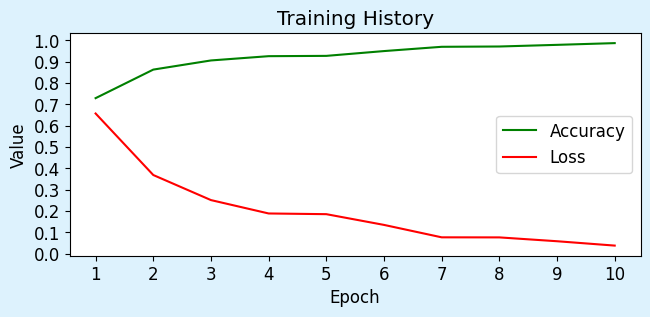

In [22]:
plt.figure(figsize=(20/3, 10/3),facecolor='#DDF2FD',)
sns.lineplot(data=history.history, x=range(1, len(history.history['sparse_categorical_accuracy']) + 1), y='sparse_categorical_accuracy', label='Accuracy', color='green')
sns.lineplot(data=history.history, x=range(1, len(history.history['loss']) + 1), y='loss', label='Loss', color='red',)
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.xticks(list(range(1,11)))
plt.yticks(np.linspace(0,1,11))
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/12 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 1/12 [00:01<00:21,  1.94s/it]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 2/12 [00:02<00:09,  1.09it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 3/12 [00:02<00:05,  1.64it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 4/12 [00:02<00:03,  2.26it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 5/12 [00:02<00:02,  2.83it/s]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 6/12 [00:02<00:01,  3.27it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 7/12 [00:03<00:01,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 8/12 [00:03<00:00,  4.22it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▌  | 9/12 [00:03<00:00,  4.27it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 10/12 [00:03<00:00,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 11/12 [00:04<00:00,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


100%|██████████| 12/12 [00:04<00:00,  4.09it/s]

1/1 [==============================] - 1s 1s/step


13it [00:05,  2.36it/s]


In [24]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       1.00      0.15      0.26       100
  meningioma       0.57      0.99      0.72       115
     notumor       0.84      0.99      0.91       105
   pituitary       1.00      0.73      0.84        74

    accuracy                           0.73       394
   macro avg       0.85      0.72      0.68       394
weighted avg       0.83      0.73      0.68       394



In [25]:
model.save("/content/drive/MyDrive/BTCmodel.h5")